In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import tempfile
import matplotlib.pyplot as plt
from datetime import datetime
import subprocess

pd.set_option("display.max_columns",30)

In [2]:
def circular_mean(series):
    """
    Calculate the mean direction for circular data (e.g., wind direction).
    """
    radians = np.deg2rad(series.dropna())
    sin_mean = np.nanmean(np.sin(radians))
    cos_mean = np.nanmean(np.cos(radians))
    mean_angle = np.arctan2(sin_mean, cos_mean)
    mean_angle_deg = np.rad2deg(mean_angle)
    if mean_angle_deg < 0:
        mean_angle_deg += 360
    return mean_angle_deg

def custom_agg(series, var_name):
    if series.isna().sum() > 20:
        return np.nan
    if var_name != 'tipping' and series.nunique() <= 3:
        return np.nan

    if var_name == 'tipping':
        return series.sum()
    elif var_name == 'wind_speed':
        return series.mean()
    elif var_name == 'wind_dir':
        return circular_mean(series)
    else:
        return series.median()


aggregation_dict = {'bmp180_temp': "mean",
                    'bmp180_pres': "mean",
                    'bmp180_slp': "mean",
                    'bmp180_alt': "mean",
                    'bmp280_temp': "mean",
                    'bmp280_pres': "mean",
                    'bmp280_slp': "mean",
                    'bmp280_alt': "mean",
                    'bme_temp': "mean",
                    'bme_pres': "mean",
                    'bme_slp': "mean",
                    'bme_alt': "mean",
                    'bme_hum': "mean",
                    'htu_temp': "mean",
                    'htu_hum': "mean",
                    'mcp9808': "mean",
                    'tipping': "sum",
                    'vis_light': "mean",
                    'ir_light': "mean",
                    'uv_light': "mean",
                    'wind_dir': "mean",
                    'wind_speed': "mean"}


def apply_aggregation(df, aggregation_dict):
    df["mcp9808"] = df['mcp9808'].replace(0.0, np.nan)
    resampled_df = df.resample('h')
    aggregated_df = pd.DataFrame()
    for var_name, agg_method in aggregation_dict.items():
        if var_name == 'wind_dir':
            aggregated_df[var_name] = resampled_df[var_name].apply(lambda x: custom_agg(x, var_name))
        else:
            aggregated_df[var_name] = resampled_df[var_name].agg(agg_method)
    return aggregated_df


In [3]:
def plot_event_comparison(event_time, 
                          hourly_df, 
                          minutely_df, 
                          variable_hourly, 
                          variable_minute, 
                          era5_variable, 
                          lat, 
                          lon, 
                          time_window=pd.Timedelta(hours=6),
                          era5_ds=None, 
                          same_y_axis=False,
                          title_suffix="",
                          save_fig=False,
                          save_path=None):
    """
    Plots a comparison between hourly and minutely measurements alongside ERA5 data for a specified event.

    Parameters:
    -----------
    event_time : pd.Timestamp
        The timestamp of the event to analyze.

    hourly_df : pd.DataFrame
        DataFrame containing hourly measurements with a DateTime index.

    minutely_df : pd.DataFrame
        DataFrame containing minutely measurements with a DateTime index.

    era5_ds : xarray.Dataset
        Xarray Dataset containing ERA5 data.

    variable_hourly : str
        Column name in `hourly_df` for the hourly measurement (e.g., "mcp9808", "tipping").

    variable_minute : str
        Column name in `minutely_df` for the minutely measurement (e.g., "mcp9808", "tipping").

    era5_variable : str
        Variable name in `era5_ds` for ERA5 data (e.g., "t2m", "tp").

    lat : float
        Latitude for ERA5 data extraction.

    lon : float
        Longitude for ERA5 data extraction.

    time_window : pd.Timedelta, optional
        Duration before and after the event to include in the analysis. Default is 6 hours.

    same_y_axis : bool, optional
        If True, plots all measurements on the same y-axis. If False, uses separate y-axes. Default is False.

    title_suffix : str, optional
        Additional string to append to the plot title. Useful for distinguishing between events. Default is "".

    save_fig : bool, optional
        If True, saves the figure to `save_path`. Default is False.

    save_path : str, optional
        File path to save the figure. Required if `save_fig` is True.

    Returns:
    --------
    None
    """
    # Define the time window
    start_time = event_time - time_window
    end_time = event_time + time_window

    # Filter the DataFrames within the time window
    filtered_hourly = hourly_df.loc[start_time:end_time]
    filtered_minutely = minutely_df.loc[start_time:end_time]
    if era5_ds:
        # Extract ERA5 data for the specified location and time window
        era5_data = era5_ds[era5_variable].sel(lat=lat, lon=lon, method='nearest')
        era5_filtered = era5_data.sel(time=slice(start_time, end_time))
        era5_pd = era5_filtered.to_pandas()

    # Ensure that the indices align for plotting
    # If not, consider resampling or interpolating
    # For simplicity, we'll assume they are aligned or handle missing data gracefully

    # Start plotting
    plt.figure(figsize=(16, 8))

    if variable_hourly == "tipping": 
        unit = "mm"
    elif variable_hourly == "wind_speed":
        unit = "m/s"
    else:
        unit = "°C"

    if same_y_axis:
        # Plot all data on the same y-axis
        plt.plot(filtered_hourly.index, filtered_hourly[variable_hourly], 
                 color='mediumblue', label=f"Hourly {variable_hourly.capitalize()}", linewidth=2, marker='x')
        plt.plot(filtered_minutely.index, filtered_minutely[variable_minute], 
                 color='orange', label=f"Minutely {variable_minute.capitalize()}", linewidth=2, marker='o', alpha=0.5, markersize=2)
        if era5_ds:
            plt.plot(era5_pd.index, era5_pd.values, 
                    color='green', label=f"ERA5 {era5_variable.upper()}", linewidth=2, marker='x')

        plt.xlabel("Datetime", fontsize=12)
        plt.ylabel(f"{variable_hourly.capitalize()} in {unit}", fontsize=12)
        plt.title(f"Event: {event_time} - {title_suffix}", fontsize=14)
        plt.grid(alpha=0.7)
        plt.legend(loc="upper right", fontsize=12)
    else:
        # Create primary y-axis
        ax1 = plt.gca()
        ax1.plot(filtered_hourly.index, filtered_hourly[variable_hourly], 
                 color='mediumblue', label=f"Hourly {variable_hourly.capitalize()}", linewidth=2, marker='x')
        ax1.set_xlabel("Datetime", fontsize=12)
        ax1.set_ylabel(f"{variable_hourly.capitalize()} in {unit} (Hourly)", fontsize=12)
        ax1.tick_params(axis='y')
        ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

        # Plot minutely data on the same primary y-axis
        ax1.plot(filtered_minutely.index, filtered_minutely[variable_minute], 
                 color='orange', label=f"Minutely {variable_minute.capitalize()}", linewidth=2, marker='o', alpha=0.5, markersize=2)
        if era5_ds:
            # Create secondary y-axis for ERA5 data
            ax2 = ax1.twinx()
            ax2.plot(era5_pd.index, era5_pd.values, 
                    color='green', label=f"ERA5 {era5_variable.upper()}", linewidth=2, marker='x')
            ax2.set_ylabel(f"ERA5 {era5_variable.upper()} in {unit}", fontsize=12)
            ax2.tick_params(axis='y')

            # Combine legends from both axes
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right", fontsize=12)

        plt.title(f"Event: {event_time} - {title_suffix}", fontsize=14)

    # Improve x-axis date formatting
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Optionally save the figure
    if save_fig:
        if save_path is None:
            raise ValueError("save_path must be provided if save_fig is True.")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    # Display the plot
    plt.show()

In [6]:
marshall_processed_df = pd.read_csv("station_data_processed/marshall_hourly_processed_data.csv", index_col=0)
marshall_processed_df.index = pd.to_datetime(marshall_processed_df.index, errors='coerce')

# Apply the optimized aggregation
marshall_hourly_df = apply_aggregation(marshall_processed_df, aggregation_dict)

In [7]:
marshall_hourly_df.dropna(how='all', axis=1, inplace=True) 
marshall_hourly_df.to_csv("station_data_processed/marshall_hourly_aggregated_data.csv")
print(marshall_hourly_df.index)
print(marshall_hourly_df.index.dtype)

DatetimeIndex(['2017-03-01 05:00:00', '2017-03-01 06:00:00',
               '2017-03-01 07:00:00', '2017-03-01 08:00:00',
               '2017-03-01 09:00:00', '2017-03-01 10:00:00',
               '2017-03-01 11:00:00', '2017-03-01 12:00:00',
               '2017-03-01 13:00:00', '2017-03-01 14:00:00',
               ...
               '2023-11-29 10:00:00', '2023-11-29 11:00:00',
               '2023-11-29 12:00:00', '2023-11-29 13:00:00',
               '2023-11-29 14:00:00', '2023-11-29 15:00:00',
               '2023-11-29 16:00:00', '2023-11-29 17:00:00',
               '2023-11-29 18:00:00', '2023-11-29 19:00:00'],
              dtype='datetime64[ns]', name='datetime', length=59151, freq='h')
datetime64[ns]


# Marshall

In [8]:
marshall_hourly_df.sort_values(by=['tipping'], ascending=False).index[0:5]


DatetimeIndex(['2020-02-08 16:00:00', '2020-02-08 17:00:00',
               '2021-02-19 17:00:00', '2020-04-03 19:00:00',
               '2018-04-13 16:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

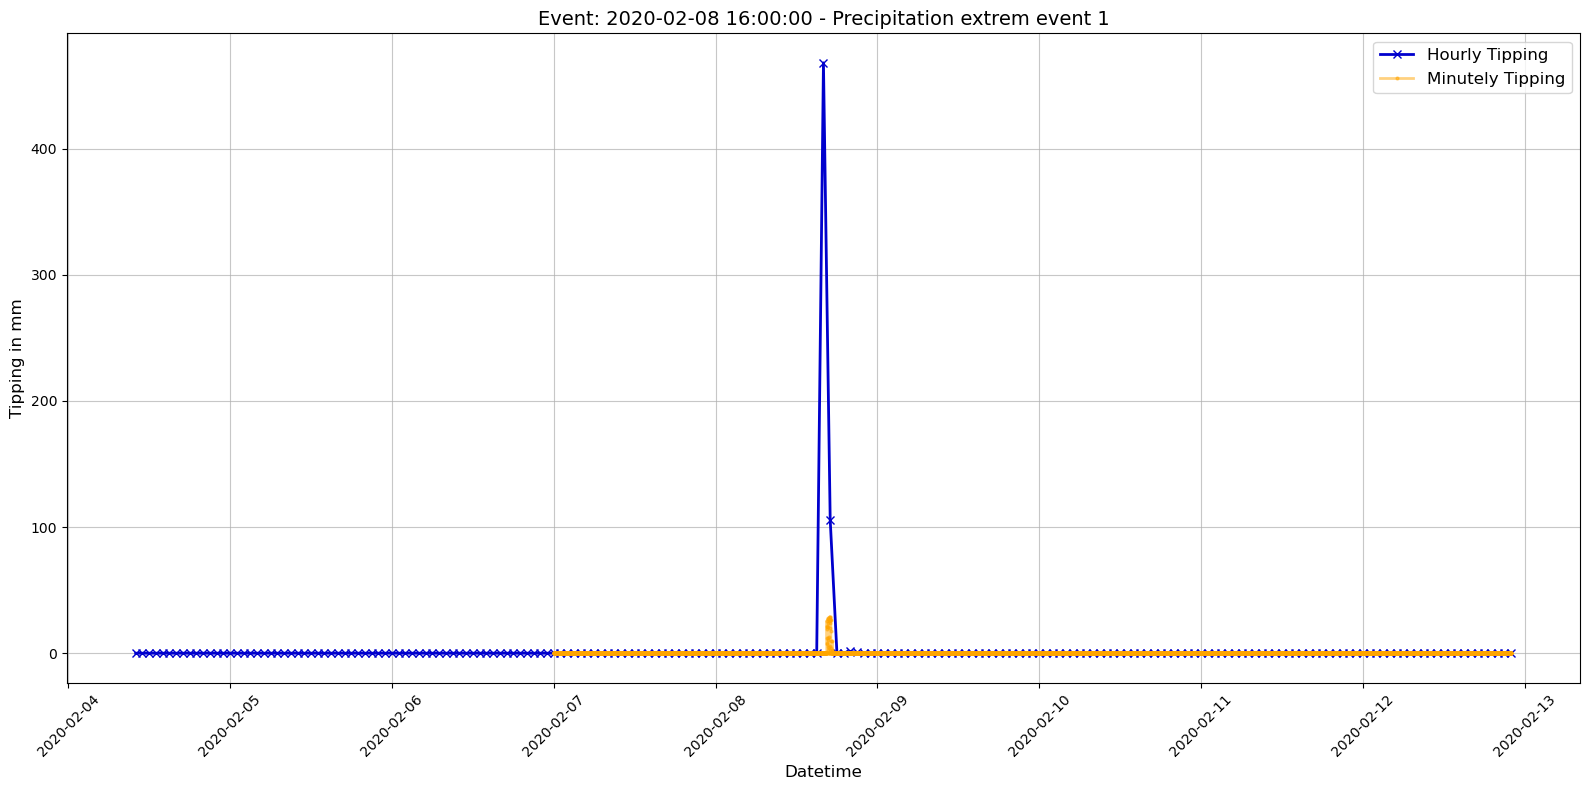

In [11]:
# Example Event 1
event_1 = pd.Timestamp("2020-02-08 16:00:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_1,
    hourly_df=marshall_hourly_df,
    minutely_df=marshall_processed_df,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tipping",              # ERA5 2-meter temperature
    lat=13.16443 ,
    lon=-59.54316,
    time_window=pd.Timedelta(hours=102),
    same_y_axis=True,
    title_suffix="Precipitation extrem event 1",
    save_fig=False
)